In [64]:
import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import Dict, List
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib as plt

In [65]:
@dataclass
class PlayerStats:
    """Player statistics configuration"""
    GOALKEEPER = {
        'Goals': -0.3,        # Negative weight for goals conceded
        'SoT%': 0.25,        # Shot stopping
        'Clr': 0.15,         # Clearances
        'TouDefPen': 0.15,   # Penalty area control
        'AerWon%': 0.15      # Aerial ability
    }

    DEFENDER = {
        'Tkl': 0.2,          # Tackling
        'Int': 0.2,          # Interceptions
        'Clr': 0.15,         # Clearances
        'AerWon%': 0.15,     # Aerial duels
        'PasTotCmp%': 0.15,  # Passing accuracy
        'Blocks': 0.15,
        'Err': -0.200,        # Blocks
        'BlkPass': 0.125,
        'Fls': -0.021,
        'Recov': 0.350
    }

    MIDFIELDER = {
        'PasTotCmp%': 0.2,   # Passing
        'PasProg': 0.2,      # Progressive passes
        'Assists': 0.15,     # Assists
        'SCA': 0.15,         # Shot creating actions
        'PPA': 0.15,         # Passes into penalty area
        'Int': 0.15,         # Interceptions
        'PasTotPrgDist':0.15,
        'Pas3rd': 0.10,
        'TB': -0.10,
        'BlkPass': 0.225,
        'CarPrgDist': 0.10,
        'CarDis': 0.10


    }

    FORWARD = {
        'Goals': 0.3,        # Goals
        'SoT%': 0.15,       # Shot accuracy
        'G/Sh': 0.15,       # Conversion rate
        'GCA': 0.15,        # Goal creating actions
        'Assists': 0.15,     # Assists
        'ToSuc%': 0.1       # Dribbling success
    }
@dataclass
class TeamStatsConfig:
    """Team statistics configuration"""
    ATTACK = {
        'GF': 0.4,
        'xG': 0.3,
        'Sh/90': 0.15,
        'Poss': 0.15
    }

    DEFENSE = {
        'GA': -0.4,
        'xGA': -0.3,
        'Clr/90': 0.15,
        'Int/90': 0.15
    }

In [66]:
class TeamPerformance:
    def __init__(self, team_stats_df: pd.DataFrame):
        self.team_stats = team_stats_df

    def calculate_team_strength(self, team: str) -> float:
        team_data = self.team_stats[self.team_stats['Squad'] == team].iloc[0]

        # Normalize team metrics
        win_rate = team_data['W'] / team_data['MP']
        goal_diff_per_game = team_data['GD'] / team_data['MP']
        xg_diff_per_game = team_data['xGD'] / team_data['MP']

        # Calculate weighted team strength
        strength = (
            0.4 * win_rate +
            0.3 * (goal_diff_per_game / 3) + # Normalize by typical max GD
            0.3 * (xg_diff_per_game / 2)     # Normalize by typical max xGD
        )

        return strength


In [67]:
class PlayerEvaluator:
    def __init__(self, player_stats_df: pd.DataFrame, team_stats_df: pd.DataFrame, stats_config: PlayerStats = None):
        self.player_stats = player_stats_df.copy()
        self.team_performance = TeamPerformance(team_stats_df)
        self.stats_config = stats_config if stats_config else PlayerStats()

    def normalize_stat(self, values: pd.Series) -> pd.Series:
        """Normalize statistics to 0-1 scale"""
        min_val = values.min()
        max_val = values.max()
        if max_val == min_val:
            return pd.Series(0.5, index=values.index)
        return (values - min_val) / (max_val - min_val)

    def calculate_player_score(self, player: pd.Series) -> float:
        """Calculate individual player score based on position and stats"""
        position = player['Pos'][:2]

        if position == 'GK':
            weights = self.stats_config.GOALKEEPER
        elif position == 'DF':
            weights = self.stats_config.DEFENDER
        elif position == 'MF':
            weights = self.stats_config.MIDFIELDER
        elif position == 'FW':
            weights = self.stats_config.FORWARD
        else:
            print(f"Warning: Unknown position {position} for player {player['Player']}")
            return 0.0

        score = 0
        position_group = self.player_stats[self.player_stats['Pos'].str.startswith(position)]

        for stat, weight in weights.items():
            if stat not in player:
                continue

            value = player[stat]
            if pd.notnull(value):
                normalized = self.normalize_stat(position_group[stat])[player.name]
                score += normalized * weight

        # Adjust score by team context
        team_strength = self.team_performance.calculate_team_strength(player['Squad'])
        final_score = score * (1 + team_strength) / 2


        return final_score

    def evaluate_all_players(self) -> pd.DataFrame:
        """Score all players in dataset"""
        self.player_stats['player_score'] = self.player_stats.apply(
            self.calculate_player_score, axis=1
        )
        return self.player_stats[['Player', 'Pos', 'Squad', 'player_score']]

    def update_weights(self, new_weights: PlayerStats):
        """Update the weights used for calculating player scores."""
        self.stats_config = new_weights


In [68]:
class MatchPredictor:
    def __init__(self, player_evaluator: PlayerEvaluator):
        self.player_evaluator = player_evaluator

    def predict_match(self, team1_players: List[str], team2_players: List[str]) -> Dict:
        """Predict match outcome between two teams"""
        # Get player scores with validation
        team1_scores = []
        team2_scores = []

        # Calculate weighted scores by position
        for player in team1_players:
            player_data = self.player_evaluator.player_stats[
                self.player_evaluator.player_stats['Player'] == player
            ]
            if not player_data.empty:
                position = player_data['Pos'].iloc[0][:2]
                score = player_data['player_score'].iloc[0]
                # Apply position-based importance
                if position == 'GK':
                    score *= 1.2  # Goalkeeper has high impact
                elif position == 'FW':
                    score *= 1.1  # Forward has above average impact
                team1_scores.append(score)

        for player in team2_players:
            player_data = self.player_evaluator.player_stats[
                self.player_evaluator.player_stats['Player'] == player
            ]
            if not player_data.empty:
                position = player_data['Pos'].iloc[0][:2]
                score = player_data['player_score'].iloc[0]
                # Apply position-based importance
                if position == 'GK':
                    score *= 1.2
                elif position == 'FW':
                    score *= 1.1
                team2_scores.append(score)

        if not team1_scores or not team2_scores:
            raise ValueError("Not enough valid players found")

        # Calculate weighted team strengths
        team1_strength = np.mean(team1_scores)
        team2_strength = np.mean(team2_scores)

        # Add team performance impact
        team1_squad = self.player_evaluator.player_stats[
            self.player_evaluator.player_stats['Player'].isin(team1_players)
        ]['Squad'].iloc[0]
        team2_squad = self.player_evaluator.player_stats[
            self.player_evaluator.player_stats['Player'].isin(team2_players)
        ]['Squad'].iloc[0]

        team1_perf = self.player_evaluator.team_performance.calculate_team_strength(team1_squad)
        team2_perf = self.player_evaluator.team_performance.calculate_team_strength(team2_squad)

        # Combine individual strength and team performance
        team1_final = team1_strength * (1 + team1_perf)
        team2_final = team2_strength * (1 + team2_perf)

        # Calculate win probability with enhanced difference
        diff = (team1_final - team2_final) * 2  # Amplify differences
        team1_win_prob = 1 / (1 + np.exp(-diff))

        return {
            'team1_win_prob': team1_win_prob,
            'team2_win_prob': 1 - team1_win_prob,
            'predicted_score_diff': diff,
            'team1_strength': team1_final,  # Add for debugging
            'team2_strength': team2_final   # Add for debugging
        }


In [69]:
class WeightTracker:
    def __init__(self):
        self.initial_weights = PlayerStats()
        self.final_weights = None

    def print_weight_comparison(self):
        """Print initial and final weights for each position"""
        positions = ['GOALKEEPER', 'DEFENDER', 'MIDFIELDER', 'FORWARD']

        for pos in positions:
            print(f"\n{pos} Position Weights:")
            print("-" * 50)
            print(f"{'Stat':<15} {'Initial':<10} {'Final':<10} {'Change':<10}")
            print("-" * 50)

            initial = getattr(self.initial_weights, pos)
            final = getattr(self.final_weights, pos) if self.final_weights else initial

            for stat in initial.keys():
                init_val = initial[stat]
                final_val = final[stat]
                change = final_val - init_val
                print(f"{stat:<15} {init_val:>8.3f}  {final_val:>8.3f}  {change:>+8.3f}")


In [70]:
# Modify PlayerScorer to track weights
class PlayerScorer:
    def __init__(self, stats_df: pd.DataFrame):
        self.stats_df = stats_df
        self.weight_tracker = WeightTracker()
        self.weights = self.weight_tracker.initial_weights

    def train(self):
        # Your existing training code here
        # After training, update final weights
        self.weight_tracker.final_weights = self.weights

    def print_weights(self):
        self.weight_tracker.print_weight_comparison()


In [71]:

class WeightLearner(nn.Module):
    def __init__(self, initial_player_weights: PlayerStats, initial_team_weights: TeamStatsConfig):
        super().__init__()

        # Randomly initialize weights
        self.gk_weights = nn.Parameter(torch.randn(len(initial_player_weights.GOALKEEPER)) * 0.1)
        self.df_weights = nn.Parameter(torch.randn(len(initial_player_weights.DEFENDER)) * 0.1)
        self.mf_weights = nn.Parameter(torch.randn(len(initial_player_weights.MIDFIELDER)) * 0.1)
        self.fw_weights = nn.Parameter(torch.randn(len(initial_player_weights.FORWARD)) * 0.1)

        self.attack_weights = nn.Parameter(torch.randn(len(initial_team_weights.ATTACK)) * 0.1)
        self.defense_weights = nn.Parameter(torch.randn(len(initial_team_weights.DEFENSE)) * 0.1)

    def forward(self, player_features: Dict[str, torch.Tensor], team_features: Dict[str, torch.Tensor]) -> torch.Tensor:
        position_scores = []
        if 'GK' in player_features:
            gk_score = torch.matmul(player_features['GK'], self.gk_weights).mean()
            position_scores.append(gk_score)
        if 'DF' in player_features:
            df_score = torch.matmul(player_features['DF'], self.df_weights).mean()
            position_scores.append(df_score)
        if 'MF' in player_features:
            mf_score = torch.matmul(player_features['MF'], self.mf_weights).mean()
            position_scores.append(mf_score)
        if 'FW' in player_features:
            fw_score = torch.matmul(player_features['FW'], self.fw_weights).mean()
            position_scores.append(fw_score)

        player_score = torch.stack(position_scores).mean() if position_scores else torch.tensor(0.0)

        attack_score = torch.dot(team_features['attack'], self.attack_weights)
        defense_score = torch.dot(team_features['defense'], self.defense_weights)

        total_score = player_score + attack_score + defense_score

        return total_score.unsqueeze(0)


In [72]:
class AdaptivePlayerScorer:
    def __init__(self, player_stats: pd.DataFrame, team_stats: pd.DataFrame, epl_results: pd.DataFrame):
        self.player_stats = player_stats.copy()
        self.team_stats = team_stats.copy()
        self.epl_results = epl_results.copy()
        self.initial_player_weights = PlayerStats()
        self.initial_team_weights = TeamStatsConfig()
        self.model = WeightLearner(self.initial_player_weights, self.initial_team_weights)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.01)

    def prepare_match_data(self):
        """Prepare matches using actual EPL results."""
        matches = []
        for _, row in self.epl_results.iterrows():
            home_team = row['HomeTeam']
            away_team = row['AwayTeam']
            result = row['FTR']  # Full Time Result: 'H', 'D', 'A'

            # Map result to target variable: 1 if home team wins, 0 otherwise
            if result == 'H':
                target = 1.0
            elif result == 'A':
                target = 0.0
            else:
                continue  # Skip draws or handle them separately if desired

            # Check if teams exist in team_stats
            if home_team not in self.team_stats['Squad'].values or away_team not in self.team_stats['Squad'].values:
                continue

            # Collect players from each team
            home_players = self.player_stats[self.player_stats['Squad'] == home_team]
            away_players = self.player_stats[self.player_stats['Squad'] == away_team]

            # Proceed only if both teams have players
            if home_players.empty or away_players.empty:
                continue

            matches.append({
                'team1': home_team,
                'team2': away_team,
                'team1_players': home_players,
                'team2_players': away_players,
                'target': target  # 1.0 for home win, 0.0 for home loss
            })
        return matches

    def train(self, epochs=50):
        matches = self.prepare_match_data()
        print(f"Starting training with {len(matches)} match pairs")
        for epoch in range(epochs):
            total_loss = self.train_epoch(matches)
            print(f"\nEpoch [{epoch+1}/{epochs}], Loss: {total_loss/len(matches):.4f}")

            # Optional: Plot distribution of targets

            # Optionally, print updated weights after each epoch
            # [Your code for printing weights]

    def get_player_features(self, team: str) -> Dict[str, torch.Tensor]:
        # Existing code remains unchanged
        team_players = self.player_stats[self.player_stats['Squad'] == team]
        features = {}
        for pos in ['GK', 'DF', 'MF', 'FW']:
            pos_players = team_players[team_players['Pos'].str.startswith(pos)]
            if not pos_players.empty:
                if pos == 'GK':
                    stats = list(self.initial_player_weights.GOALKEEPER.keys())
                elif pos == 'DF':
                    stats = list(self.initial_player_weights.DEFENDER.keys())
                elif pos == 'MF':
                    stats = list(self.initial_player_weights.MIDFIELDER.keys())
                else:
                    stats = list(self.initial_player_weights.FORWARD.keys())
                pos_features = pos_players[stats].fillna(0.0).values

                # Add normalization
                scaler = StandardScaler()
                pos_features = scaler.fit_transform(pos_features)
                features[pos] = torch.tensor(pos_features, dtype=torch.float32)
        return features

    def get_team_features(self, team: str) -> Dict[str, torch.Tensor]:
        # Existing code remains unchanged
        team_data = self.team_stats[self.team_stats['Squad'] == team].iloc[0]
        attack_stats = list(self.initial_team_weights.ATTACK.keys())
        defense_stats = list(self.initial_team_weights.DEFENSE.keys())
        attack_values = np.array([team_data.get(stat, 0.0) for stat in attack_stats], dtype=np.float32)
        defense_values = np.array([team_data.get(stat, 0.0) for stat in defense_stats], dtype=np.float32)

        # Add normalization
        attack_values = (attack_values - attack_values.mean()) / (attack_values.std() + 1e-6)
        defense_values = (defense_values - defense_values.mean()) / (defense_values.std() + 1e-6)

        attack_features = torch.tensor(attack_values, dtype=torch.float32)
        defense_features = torch.tensor(defense_values, dtype=torch.float32)
        return {'attack': attack_features, 'defense': defense_features}

    def train_epoch(self, matches):
        total_loss = 0.0
        for match in matches:
            self.optimizer.zero_grad()

            # Get player features directly from DataFrames
            team1_player_features = self.get_player_features_from_df(match['team1_players'])
            team2_player_features = self.get_player_features_from_df(match['team2_players'])

            # Get team features
            team1_team_features = self.get_team_features(match['team1'])
            team2_team_features = self.get_team_features(match['team2'])

            # Forward pass
            team1_score = self.model(team1_player_features, team1_team_features)
            team2_score = self.model(team2_player_features, team2_team_features)

            # Calculate predicted win probability
            pred_prob = torch.sigmoid(team1_score - team2_score)

            # Corrected line: use 'target' instead of 'win_prob'
            target = torch.tensor([match['target']], dtype=torch.float32)

            # Compute loss
            loss = F.binary_cross_entropy(pred_prob, target)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
        return total_loss

    def get_final_weights(self):
        final_player_weights = PlayerStats()
        final_team_weights = TeamStatsConfig()

        final_player_weights.GOALKEEPER = dict(zip(
            self.initial_player_weights.GOALKEEPER.keys(),
            self.model.gk_weights.detach().numpy()))
        final_player_weights.DEFENDER = dict(zip(
            self.initial_player_weights.DEFENDER.keys(),
            self.model.df_weights.detach().numpy()))
        final_player_weights.MIDFIELDER = dict(zip(
            self.initial_player_weights.MIDFIELDER.keys(),
            self.model.mf_weights.detach().numpy()))
        final_player_weights.FORWARD = dict(zip(
            self.initial_player_weights.FORWARD.keys(),
            self.model.fw_weights.detach().numpy()))

        final_team_weights.ATTACK = dict(zip(
            self.initial_team_weights.ATTACK.keys(),
            self.model.attack_weights.detach().numpy()))
        final_team_weights.DEFENSE = dict(zip(
            self.initial_team_weights.DEFENSE.keys(),
            self.model.defense_weights.detach().numpy()))

        return final_player_weights, final_team_weights

    def get_player_features_from_df(self, team_players_df: pd.DataFrame) -> Dict[str, torch.Tensor]:
        features = {}
        positions = {'GK': 'GOALKEEPER', 'DF': 'DEFENDER', 'MF': 'MIDFIELDER', 'FW': 'FORWARD'}
        for pos_code, pos_name in positions.items():
            pos_players = team_players_df[team_players_df['Pos'].str.startswith(pos_code)]
            if not pos_players.empty:
                stats = list(getattr(self.initial_player_weights, pos_name).keys())
                pos_features = pos_players[stats].fillna(0.0).values

                # Normalize features
                scaler = StandardScaler()
                pos_features = scaler.fit_transform(pos_features)
                pos_features = np.nan_to_num(pos_features)

                features[pos_code] = torch.tensor(pos_features, dtype=torch.float32)
        return features

Pre Train

In [73]:
# Load EPL results dataset
epl_results = pd.read_csv('epl_results.csv')

# Ensure team names match across datasets
team_name_mapping = {
    # Not required
}

# Apply mapping to HomeTeam and AwayTeam
epl_results.replace({'HomeTeam': team_name_mapping, 'AwayTeam': team_name_mapping}, inplace=True)

# Get list of EPL teams from epl_results
epl_teams = pd.unique(epl_results[['HomeTeam', 'AwayTeam']].values.ravel())

# Filter team_stats and player_stats
epl_team_stats = team_stats[team_stats['Squad'].isin(epl_teams)].reset_index(drop=True)
epl_player_stats = player_stats[player_stats['Squad'].isin(epl_teams)].reset_index(drop=True)

In [75]:
if __name__ == "__main__":
    # Load data
    player_stats = pd.read_csv('player_stats.csv', sep=';', encoding='latin-1')
    team_stats = pd.read_csv('team_stats.csv', sep=';', encoding='latin-1')

    # Initialize evaluator and calculate scores
    evaluator = PlayerEvaluator(player_stats, team_stats)
    player_scores = evaluator.evaluate_all_players()

    predictor = MatchPredictor(evaluator)

    # Example prediction
    team1 = ['Doðan Alemdar', 'Yunis Abdelhamid', 'Abner', 'Francesco Acerbi',
             'Marcos Acuña', 'Brenden Aaronson', 'Himad Abdelli', 'Salis Abdul Samed',
             'Matthis Abline', 'Matthis Abline', 'Zakaria Aboukhlal']

    team2 = ['Alisson', 'Tosin Adarabioyo', 'Emmanuel Agbadou', 'Felix Agu',
             'Nayef Aguerd', 'Laurent Abergel', 'Oliver Abildgaard', 'Tyler Adams',
             'Tammy Abraham', 'Mohamed Achi', 'Che Adams']

    result = predictor.predict_match(team1, team2)
    print("\nMatch prediction:")
    print(f"Team 1 strength: {result['team1_strength']:.3f}")
    print(f"Team 2 strength: {result['team2_strength']:.3f}")
    print(f"Team 1 win probability: {result['team1_win_prob']:.3f}")
    print(f"Team 2 win probability: {result['team2_win_prob']:.3f}")

    # Initialize and train adaptive scorer
    scorer = AdaptivePlayerScorer(player_stats, team_stats, epl_results)
    scorer.train(epochs=200)

    # Get and print learned weights
    final_player_weights, final_team_weights = scorer.get_final_weights()

    # Print comparison
    weight_tracker = WeightTracker()
    weight_tracker.initial_weights = PlayerStats()
    weight_tracker.final_weights = final_player_weights  # Assign only player weights
    weight_tracker.print_weight_comparison()



Match prediction:
Team 1 strength: 0.159
Team 2 strength: 0.161
Team 1 win probability: 0.499
Team 2 win probability: 0.501
Starting training with 140 match pairs

Epoch [1/200], Loss: 0.6804

Epoch [2/200], Loss: 0.6629

Epoch [3/200], Loss: 0.6529

Epoch [4/200], Loss: 0.6467

Epoch [5/200], Loss: 0.6428

Epoch [6/200], Loss: 0.6402

Epoch [7/200], Loss: 0.6385

Epoch [8/200], Loss: 0.6372

Epoch [9/200], Loss: 0.6363

Epoch [10/200], Loss: 0.6356

Epoch [11/200], Loss: 0.6351

Epoch [12/200], Loss: 0.6346

Epoch [13/200], Loss: 0.6341

Epoch [14/200], Loss: 0.6338

Epoch [15/200], Loss: 0.6334

Epoch [16/200], Loss: 0.6331

Epoch [17/200], Loss: 0.6328

Epoch [18/200], Loss: 0.6324

Epoch [19/200], Loss: 0.6321

Epoch [20/200], Loss: 0.6318

Epoch [21/200], Loss: 0.6315

Epoch [22/200], Loss: 0.6313

Epoch [23/200], Loss: 0.6310

Epoch [24/200], Loss: 0.6307

Epoch [25/200], Loss: 0.6304

Epoch [26/200], Loss: 0.6301

Epoch [27/200], Loss: 0.6299

Epoch [28/200], Loss: 0.6296

Epoc

Train

In [76]:


# Example prediction (One sided team)
team1 = ['Doðan Alemdar', 'Yunis Abdelhamid', 'Abner', 'Francesco Acerbi',
          'Marcos Acuña', 'Diego Demme ', 'Himad Abdelli', 'Salis Abdul Samed',
          'Matthis Abline', 'Matthis Abline', 'Zakaria Aboukhlal']

team2 = ['Alisson', 'Mario Suárez', 'Emmanuel Agbadou', 'Felix Agu',
          'Nayef Aguerd', 'Laurent Abergel', 'Oliver Abildgaard', 'Alessandro Cortinovis',
          'Tammy Abraham', 'Kylian Mbappé ', 'Erling Haaland']


# Update the PlayerEvaluator with new weights
evaluator.update_weights(final_player_weights)

# Re-evaluate all player scores with updated weights
player_scores = evaluator.evaluate_all_players()

# Re-initialize evaluator with new weights
evaluator = PlayerEvaluator(player_stats, team_stats, stats_config=final_player_weights)
player_scores = evaluator.evaluate_all_players()

# Re-initialize predictor with updated evaluator
predictor = MatchPredictor(evaluator)

# Make new prediction with updated weights
result = predictor.predict_match(team1, team2)
print("\nUpdated Match prediction with learned weights:")
print(f"Team 1 strength: {result['team1_strength']:.3f}")
print(f"Team 2 strength: {result['team2_strength']:.3f}")
print(f"Team 1 win probability: {result['team1_win_prob']:.3f}")
print(f"Team 2 win probability: {result['team2_win_prob']:.3f}")


Updated Match prediction with learned weights:
Team 1 strength: -1.316
Team 2 strength: 0.461
Team 1 win probability: 0.028
Team 2 win probability: 0.972


Post

<ipython-input-77-e8d5877911cd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_scores['normalized_score'] = 0.0



Top 20 Players (Normalized by Position):
--------------------------------------------------------------------------------
Rank Player                        Position  Team                          Score
--------------------------------------------------------------------------------
1    Diego Demme                   MF        Napoli                        7.634
2    Erling Haaland                FW        Manchester City               6.749
3    Mario Suárez                  DFMF      Rayo Vallecano                6.083
4    Dany Jean                     DF        Strasbourg                    5.982
5    Alessandro Cortinovis         MF        Hellas Verona                 5.825
6    Casemiro                      MF        Real Madrid                   4.350
7    Tanguy Coulibaly              DFFW      Stuttgart                     4.311
8    Victor Osimhen                FW        Napoli                        4.253
9    Marvin Senaya                 DF        Strasbourg            

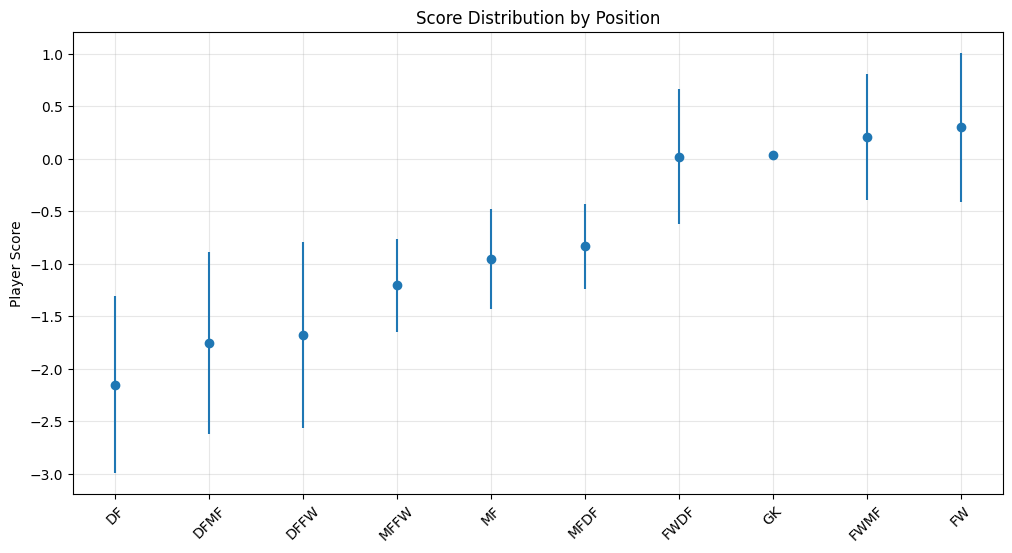

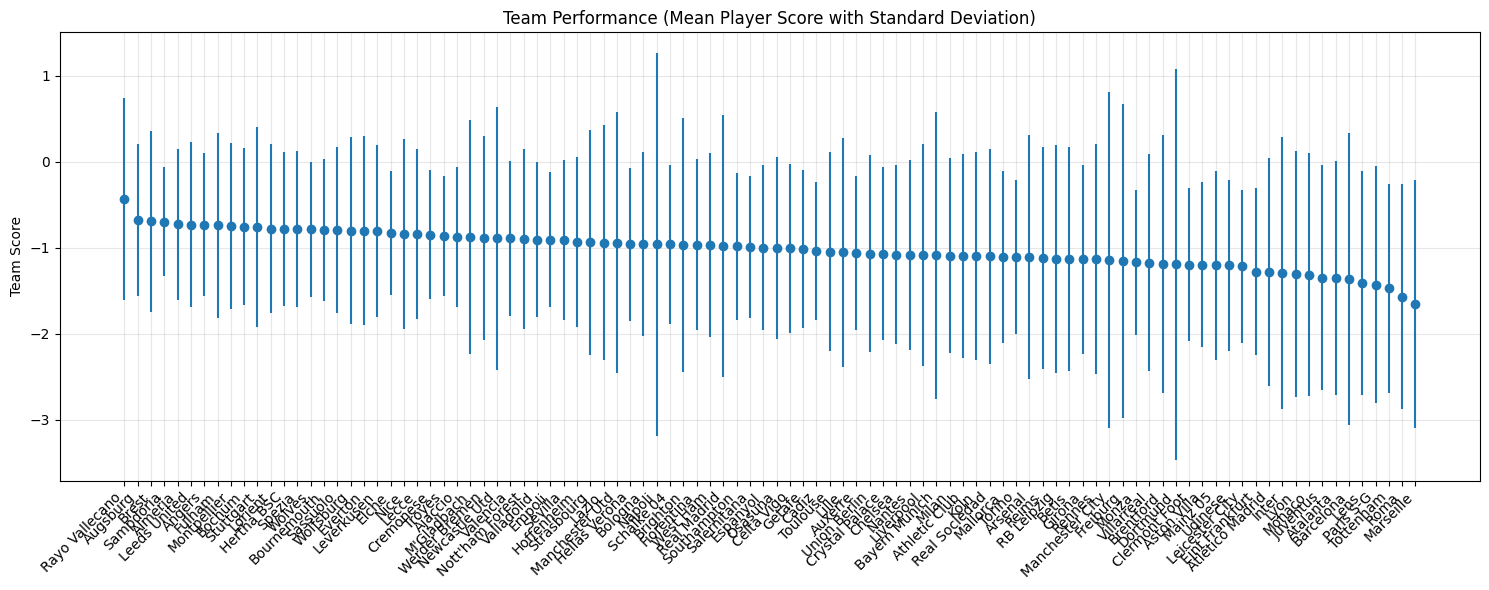

In [77]:
def analyze_and_visualize_players(player_scores: pd.DataFrame):
    import matplotlib.pyplot as plt

    # 1. Create normalized scores within each position
    player_scores['normalized_score'] = 0.0
    for pos in ['GK', 'DF', 'MF', 'FW']:
        pos_mask = player_scores['Pos'].str.startswith(pos)
        scores = player_scores.loc[pos_mask, 'player_score']
        if len(scores) > 0:  # Check if we have players in this position
            player_scores.loc[pos_mask, 'normalized_score'] = (scores - scores.mean()) / scores.std()

    # 3. Print top 20 players overall with position context
    print("\nTop 20 Players (Normalized by Position):")
    print("-" * 80)
    print(f"{'Rank':<5}{'Player':<30}{'Position':<10}{'Team':<25}{'Score':>10}")
    print("-" * 80)

    top_players = player_scores.nlargest(20, 'normalized_score')
    for idx, row in enumerate(top_players.itertuples(), 1):
        print(f"{idx:<5}{row.Player:<30}{row.Pos:<10}{row.Squad:<25}{row.normalized_score:>10.3f}")

    # 4. Position distribution
    plt.figure(figsize=(12, 6))
    positions = player_scores.groupby('Pos')['player_score'].agg(['mean', 'std']).sort_values('mean')
    plt.errorbar(range(len(positions)), positions['mean'], yerr=positions['std'], fmt='o')
    plt.xticks(range(len(positions)), positions.index, rotation=45)
    plt.title('Score Distribution by Position')
    plt.ylabel('Player Score')
    plt.grid(True, alpha=0.3)
    plt.show()

    # 5. Team strength visualization
    plt.figure(figsize=(15, 6))
    team_scores = player_scores.groupby('Squad')['player_score'].agg(['mean', 'std']).sort_values('mean', ascending=False)
    plt.errorbar(range(len(team_scores)), team_scores['mean'], yerr=team_scores['std'], fmt='o')
    plt.xticks(range(len(team_scores)), team_scores.index, rotation=45, ha='right')
    plt.title('Team Performance (Mean Player Score with Standard Deviation)')
    plt.ylabel('Team Score')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# After model training and scoring, call:
analyze_and_visualize_players(player_scores)